<a href="https://colab.research.google.com/github/Dejiy/credit-default-prediction/blob/main/Loan-risk-assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving default of credit card clients.xls to default of credit card clients.xls


In [ ]:
# 0) Verify the XLS file is present in the workspace
import os
print(os.listdir("."))  # should include "default of credit card clients.xls"


['.config', 'default of credit card clients.xls', 'sample_data']


In [ ]:
import pandas as pd

# 1) First attempt: read the Excel file with default header
df = pd.read_excel("default of credit card clients.xls")

# 2) Standardize column names: strip whitespace and lower-case for consistency
df.columns = [c.strip().lower() for c in df.columns]

# 3) Inspect column names
print(df.columns.tolist())

# 4) If the target column isn't found, the file likely has an extra header row.
#    The official UCI file often needs header=1 to skip the first row.
if "default payment next month" not in df.columns and "default" not in df.columns:
    df = pd.read_excel("default of credit card clients.xls", header=1)
    df.columns = [c.strip().lower() for c in df.columns]
    print("Reloaded with header=1. Columns:", df.columns.tolist())


['unnamed: 0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'y']
Reloaded with header=1. Columns: ['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default payment next month']


In [ ]:
# 5) Identify the target column (UCI naming uses "default payment next month")
target_candidates = ["default", "default payment next month"]
target_col = None
for cand in target_candidates:
    if cand in df.columns:
        target_col = cand
        break

if target_col is None:
    raise ValueError("Target column not found. Check df.columns output and adjust the name accordingly.")

# 6) Optional: rename the target to simply 'default' for convenience
if target_col != "default":
    df.rename(columns={target_col: "default"}, inplace=True)
    target_col = "default"

# 7) Drop obvious non-feature columns if present (e.g., 'id')
drop_candidates = ["id"]
to_drop = [c for c in drop_candidates if c in df.columns]
if to_drop:
    df.drop(columns=to_drop, inplace=True)

# 8) Quick data health check
print(df.head())
print(df.info())
print(df.isna().sum().sort_values(ascending=False).head(10))  # top missing counts


   limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   pay_5  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...      20940      19146      19131      2000     36681     10000   

   pay_amt4  pay_amt5  pay_amt6  default  
0         0         0    

In [ ]:
# 9) If there are missing values, we can impute simple strategies for a prototype
from sklearn.impute import SimpleImputer
import numpy as np

# Separate features and target
X = df.drop(columns=["default"])
y = df["default"]

# 10) Ensure target is integer/binary (some Excel reads can produce float/object)
y = y.astype(int)

# 11) Impute numeric columns with median
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]

num_imputer = SimpleImputer(strategy="median")
X_numeric = pd.DataFrame(num_imputer.fit_transform(X[numeric_cols]), columns=numeric_cols)

# 12) For a quick prototype, treat categorical columns (if any) with most_frequent imputation and one-hot encode
if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols)
    X = pd.concat([X_numeric, X_cat], axis=1)
else:
    X = X_numeric

print("Final feature columns:", X.columns.tolist())


Final feature columns: ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 13) Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 14) Scale numeric features (recommended for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

# 15) Initialize and train the model
model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# 16) Predictions and probabilities
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

# 17) Core metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# 18) Confusion matrix and detailed report
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8083333333333333
Precision: 0.6973293768545994
Recall: 0.2360622802611753
ROC-AUC: 0.7150297683562334
Confusion matrix:
 [[6805  204]
 [1521  470]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



In [ ]:
import numpy as np

# 19) Default threshold is 0.5; adjust threshold for business trade-offs
threshold = 0.35  # example: more sensitive to catching potential defaults
y_pred_custom = (y_prob >= threshold).astype(int)

print("Accuracy (thr=0.35):", accuracy_score(y_test, y_pred_custom))
print("Precision (thr=0.35):", precision_score(y_test, y_pred_custom))
print("Recall (thr=0.35):", recall_score(y_test, y_pred_custom))


Accuracy (thr=0.35): 0.8082222222222222
Precision (thr=0.35): 0.596504005826657
Recall (thr=0.35): 0.41135107985936714


In [ ]:
# 21) Simulate loan amounts and compute Expected Loss (EL)
# For demo: assume each test sample is a loan with a random amount between ₦50k and ₦500k
rng = np.random.default_rng(42)
loan_amounts = rng.integers(50_000, 500_001, size=len(y_prob))

expected_loss = y_prob * loan_amounts  # PD * LoanAmount

# 22) Portfolio metrics
total_expected_loss = expected_loss.sum()
avg_expected_loss = expected_loss.mean()

print(f"Total Expected Loss (portfolio): ₦{int(total_expected_loss):,}")
print(f"Average Expected Loss per loan: ₦{int(avg_expected_loss):,}")


Total Expected Loss (portfolio): ₦542,300,391
Average Expected Loss per loan: ₦60,255


In [ ]:
import joblib

# 23) Save the scaler and model for future use in your fintech backend
joblib.dump(scaler, "scaler.joblib")
joblib.dump(model, "logreg_model.joblib")
print("Artifacts saved: scaler.joblib, logreg_model.joblib")


Artifacts saved: scaler.joblib, logreg_model.joblib


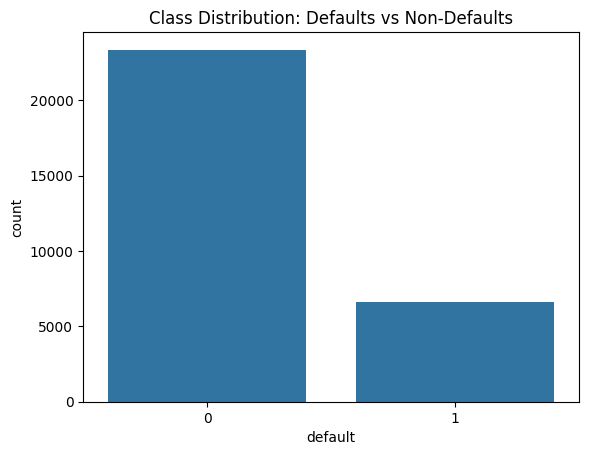

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Class Distribution: Defaults vs Non-Defaults")
plt.show()


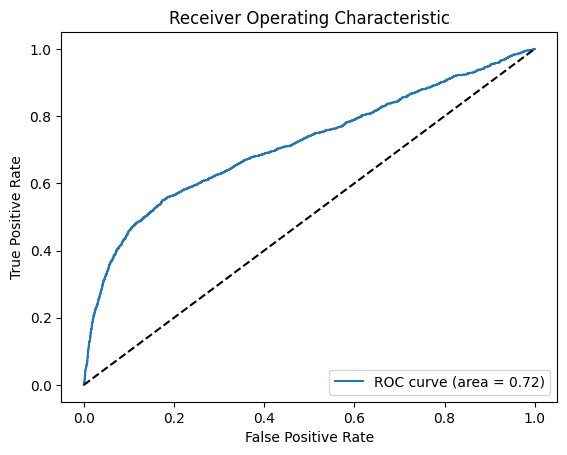

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


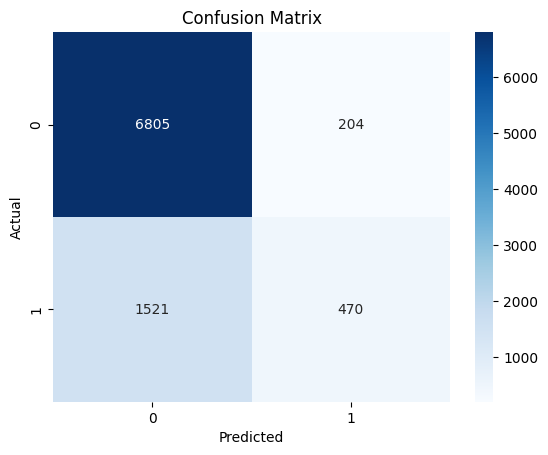

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# 1) Train Random Forest (no need to scale features)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)  # use unscaled X_train for trees
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RF Precision:", precision_score(y_test, y_pred_rf))
print("RF Recall:", recall_score(y_test, y_pred_rf))
print("RF ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


RF Accuracy: 0.8043333333333333
RF Precision: 0.562910284463895
RF Recall: 0.5168257157207433
RF ROC-AUC: 0.7732887234959945


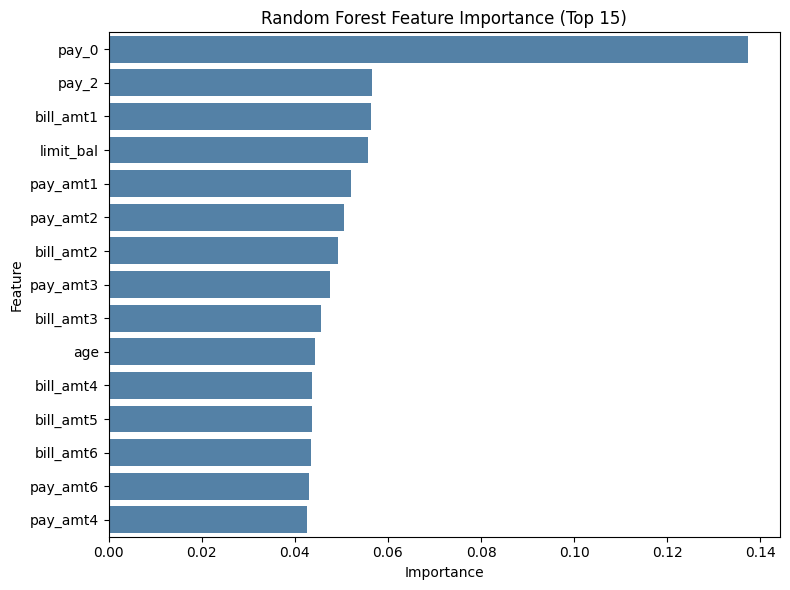

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build importance dataframe
importances = rf.feature_importances_
feat_names = X_train.columns
imp_df = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)

# Plot top 15
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df.head(15), x="importance", y="feature", color="steelblue")
plt.title("Random Forest Feature Importance (Top 15)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


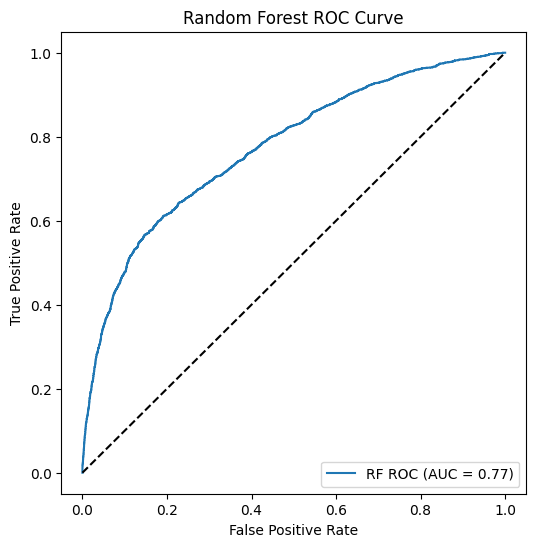

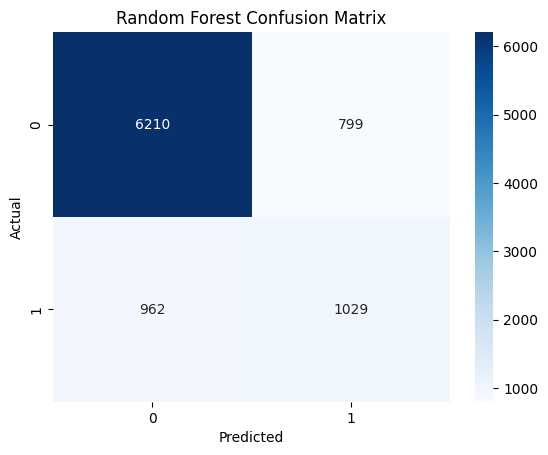

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, auc

# ROC
fpr, tpr, thr = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"RF ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


RF Accuracy (thr=0.35): 0.7444444444444445
RF Precision (thr=0.35): 0.4455026455026455
RF Recall (thr=0.35): 0.6343545956805625


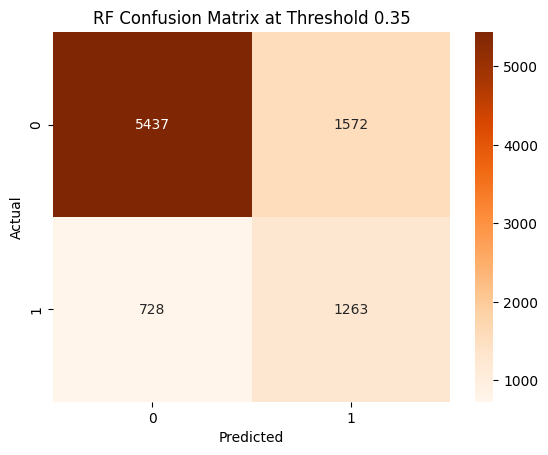

In [ ]:
# Adjust threshold to increase recall (catch more defaulters)
threshold = 0.35
y_pred_rf_t = (y_prob_rf >= threshold).astype(int)

print("RF Accuracy (thr=0.35):", accuracy_score(y_test, y_pred_rf_t))
print("RF Precision (thr=0.35):", precision_score(y_test, y_pred_rf_t))
print("RF Recall (thr=0.35):", recall_score(y_test, y_pred_rf_t))

cm_t = confusion_matrix(y_test, y_pred_rf_t)
sns.heatmap(cm_t, annot=True, fmt="d", cmap="Oranges")
plt.title("RF Confusion Matrix at Threshold 0.35")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
from ipywidgets import interact

# Function to plot confusion matrix at a given threshold
def plot_confusion(threshold=0.5):
    y_pred_thresh = (y_prob_rf >= threshold).astype(int)  # adjust predictions
    cm = confusion_matrix(y_test, y_pred_thresh)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix at Threshold = {threshold:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Create interactive slider (threshold between 0.1 and 0.9)
interact(plot_confusion, threshold=widgets.FloatSlider(value=0.5, min=0.1, max=0.9, step=0.05))


interactive(children=(FloatSlider(value=0.5, description='threshold', max=0.9, min=0.1, step=0.05), Output()),…

<function __main__.plot_confusion(threshold=0.5)>

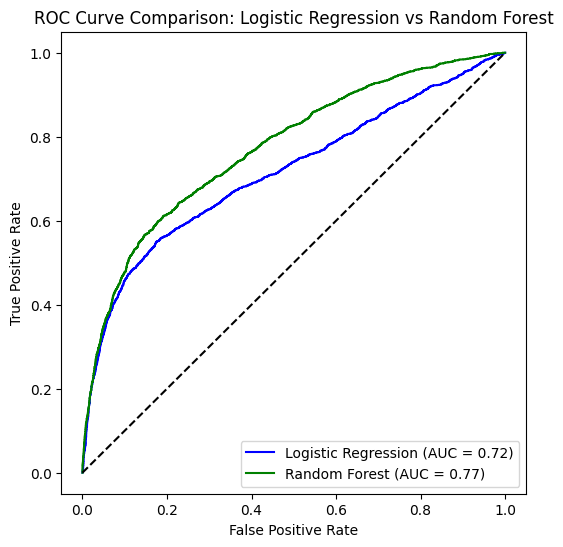

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)   # y_prob from logistic regression
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf) # y_prob_rf from random forest
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot both curves
plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color="blue")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color="green")
plt.plot([0,1],[0,1],'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Logistic Regression vs Random Forest")
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd

# Collect metrics for both models
results = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_rf)
    ]
}

df_results = pd.DataFrame(results)
print(df_results)


                 Model  Accuracy  Precision    Recall   ROC-AUC
0  Logistic Regression  0.808333   0.697329  0.236062  0.715030
1        Random Forest  0.804333   0.562910  0.516826  0.773289
